In [24]:
# UEMOA Banking Risk Assessment - Linear Regression Model
# Mission: Predict Bank Financial Health (Zscore) in UEMOA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🏦 UEMOA Banking Risk Assessment System")
print("=" * 50)


🏦 UEMOA Banking Risk Assessment System


In [25]:
# Load the dataset
df = pd.read_csv('UEMOA_Banking.csv', encoding='ISO-8859-1')

# Clean column names and handle encoding issues
df = df.drop(df.columns[0], axis=1)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Dataset shape: (742, 19)
Columns: ['Countries_Num', 'id', 'Countries', 'Banks', 'Year', 'RIR', 'SFS', 'INF', 'ERA', 'INL', 'Zscore', 'DEBT', 'SIZE', 'CC', 'GE', 'PS', 'RQ', 'RL', 'VA']


In [3]:
# Fix encoding issues in Countries column
df['Countries'] = df['Countries'].str.replace('B�nin', 'Benin')
df['Countries'] = df['Countries'].str.replace('C�te', 'Cote')

print("\n📊 Dataset Overview:")
print(df.head())

print("\n🔍 Data Quality Assessment:")
print(df.info())
print("\n📈 Statistical Summary:")
print(df.describe())

# Check for missing values
print("\n❓ Missing Values:")
print(df.isnull().sum())



📊 Dataset Overview:
   Countries_Num  id Countries                     Banks  Year       RIR  \
0              1   1     Bénin  Banque Atlantique BÃ©nin  2013  3.836593   
1              1   1     Bénin  Banque Atlantique BÃ©nin  2014  5.599992   
2              1   1     Bénin  Banque Atlantique BÃ©nin  2015  4.266334   
3              1   1     Bénin  Banque Atlantique BÃ©nin  2016  4.580100   
4              1   1     Bénin  Banque Atlantique BÃ©nin  2017  7.329021   

         SFS       INF       ERA        INL    Zscore       DEBT       SIZE  \
0  26.861971  0.428889  3.196428  12.076596  0.973123  18.503746  12.222694   
1  29.965430 -0.548758  3.045024   8.884912  1.098355  22.282075  12.271219   
2  30.984761  0.218786  2.394557   8.583933  0.649069  30.900230  12.511530   
3  29.832095 -0.794050  3.712403   5.720476  0.846807  35.923350  12.599141   
4  28.630991  1.769412  3.833422   6.256669  0.599062  39.598463  12.706508   

         CC        GE        PS        RQ      

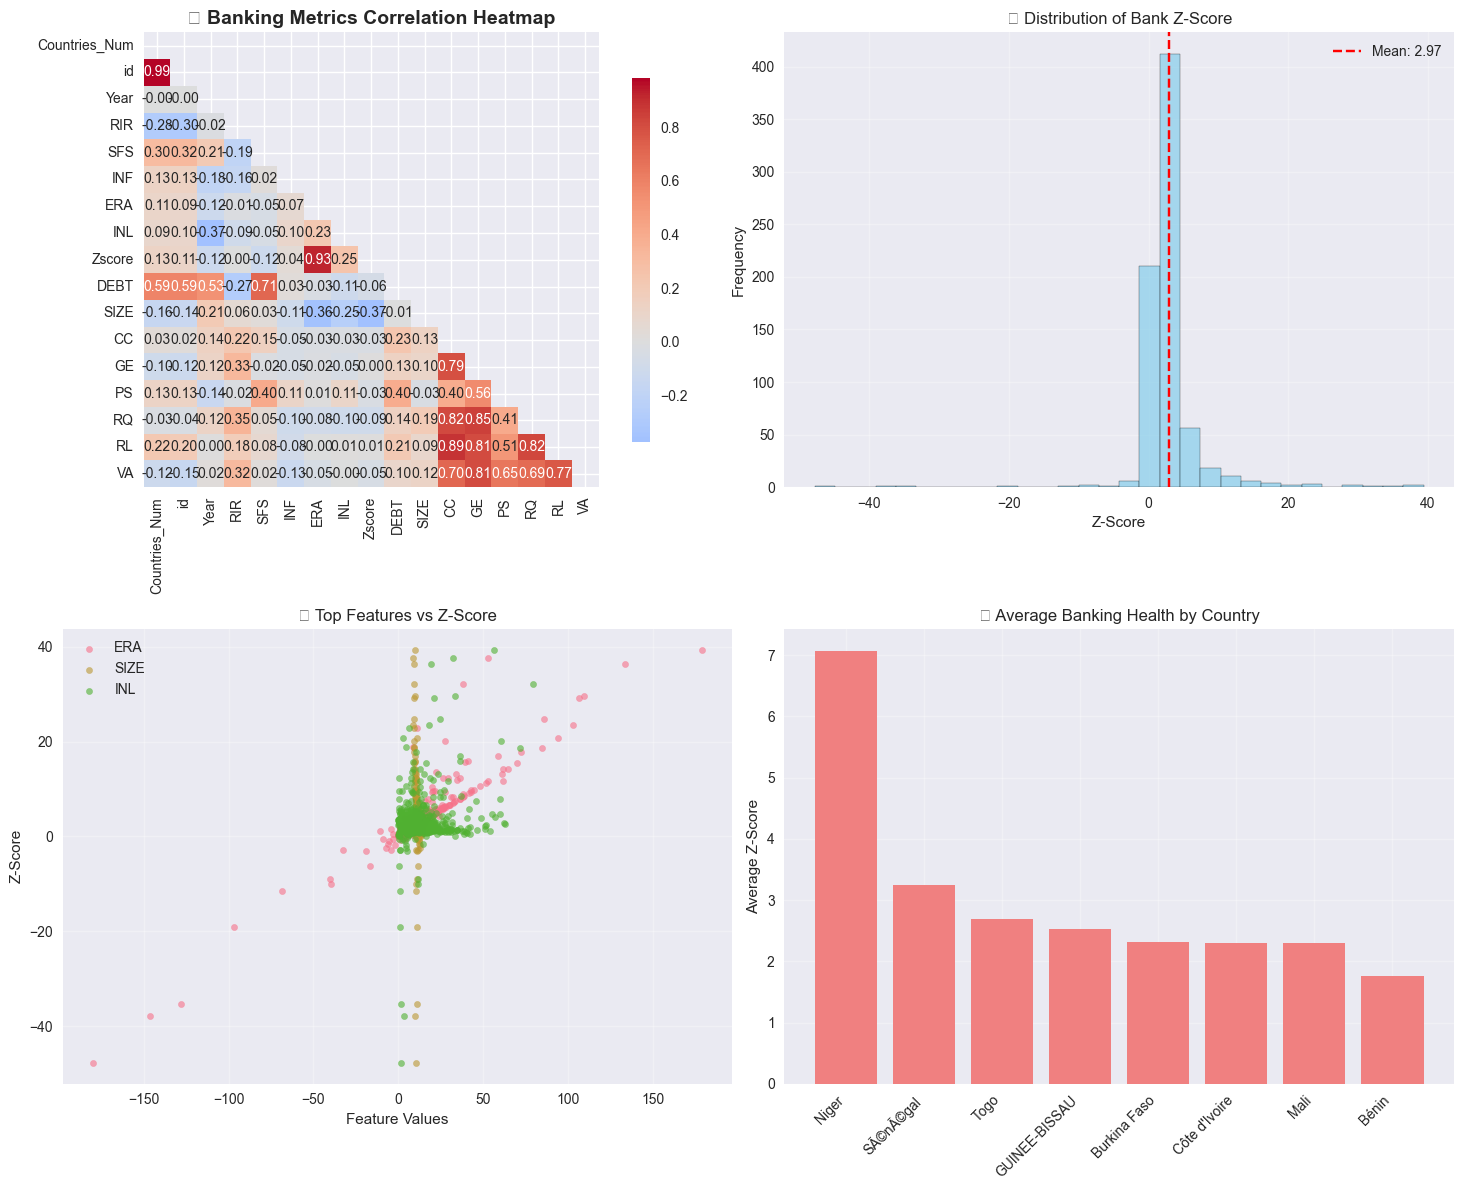

In [26]:
# Correlation Heatmap
plt.figure(figsize=(15, 12))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('📊 Banking Metrics Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()

# Distribution of Target Variable
plt.subplot(2, 2, 2)
plt.hist(df['Zscore'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(df['Zscore'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["Zscore"].mean():.2f}')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('📈 Distribution of Bank Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)

# Top Feature Relationships
plt.subplot(2, 2, 3)
zscore_corr = correlation_matrix['Zscore'].abs().sort_values(ascending=False)[1:6]
top_features = zscore_corr.index.tolist()
for i, feature in enumerate(top_features[:3]):
    plt.scatter(df[feature], df['Zscore'], alpha=0.6, label=feature, s=20)
plt.xlabel('Feature Values')
plt.ylabel('Z-Score')
plt.title('🎯 Top Features vs Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)

# Country-wise Zscore
plt.subplot(2, 2, 4)
country_zscore = df.groupby('Countries')['Zscore'].mean().sort_values(ascending=False)
plt.bar(range(len(country_zscore)), country_zscore.values, color='lightcoral')
plt.xticks(range(len(country_zscore)), country_zscore.index, rotation=45, ha='right')
plt.ylabel('Average Z-Score')
plt.title('🌍 Average Banking Health by Country')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('banking_analysis_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
print(f"\n🎯 Target Variable Analysis:")
print(f"Z-Score Range: {df['Zscore'].min():.3f} to {df['Zscore'].max():.3f}")
print(f"Z-Score Mean: {df['Zscore'].mean():.3f}")
print(f"Z-Score Std: {df['Zscore'].std():.3f}")

# Encode categorical variables
le_countries = LabelEncoder()
le_banks = LabelEncoder()
df['Countries_Encoded'] = le_countries.fit_transform(df['Countries'])
df['Banks_Encoded'] = le_banks.fit_transform(df['Banks'])

# Engineered features
df['Risk_Debt_Ratio'] = df['RIR'] * df['DEBT']
df['Stability_Size_Ratio'] = df['SFS'] / (df['SIZE'] + 1)
df['Governance_Performance'] = (df['GE'] + df['PS']) / 2

feature_cols = ['Countries_Num', 'Year', 'RIR', 'SFS', 'INF', 'ERA', 'INL', 
                'DEBT', 'SIZE', 'CC', 'GE', 'PS', 'RQ', 'RL', 'VA',
                'Countries_Encoded', 'Banks_Encoded', 'Risk_Debt_Ratio', 
                'Stability_Size_Ratio', 'Governance_Performance']

X = df[feature_cols]
y = df['Zscore']
print(f"Features selected: {len(feature_cols)}")



🎯 Target Variable Analysis:
Z-Score Range: -47.777 to 39.381
Z-Score Mean: 2.968
Z-Score Std: 5.123
Features selected: 20


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n📊 Data Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print("\n✅ Data preprocessing completed!")



📊 Data Split:
Training set: 593 samples
Test set: 149 samples

✅ Data preprocessing completed!


In [28]:
class GradientDescentLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.train_losses = []
        self.test_losses = []

    def fit(self, X, y, X_test=None, y_test=None):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            train_cost = np.mean((y_pred - y) ** 2)
            self.train_losses.append(train_cost)

            if X_test is not None and y_test is not None:
                y_test_pred = np.dot(X_test, self.weights) + self.bias
                test_cost = np.mean((y_test_pred - y_test) ** 2)
                self.test_losses.append(test_cost)

            dw = (2/n_samples) * np.dot(X.T, (y_pred - y))
            db = (2/n_samples) * np.sum(y_pred - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


In [29]:
# Gradient Descent Model
gd_model = GradientDescentLinearRegression(learning_rate=0.01, n_iterations=1000)
gd_model.fit(X_train_scaled, y_train, X_test_scaled, y_test)

gd_train_pred = gd_model.predict(X_train_scaled)
gd_test_pred = gd_model.predict(X_test_scaled)
gd_r2 = r2_score(y_test, gd_test_pred)
gd_test_mse = mean_squared_error(y_test, gd_test_pred)

# Scikit-learn Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_r2 = r2_score(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_r2 = r2_score(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)

# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)
dt_r2 = r2_score(y_test, dt_pred)
dt_mse = mean_squared_error(y_test, dt_pred)

# Compare
models_performance = {
    'Gradient Descent LR': {'mse': gd_test_mse, 'r2': gd_r2, 'model': gd_model},
    'Scikit-learn LR': {'mse': lr_mse, 'r2': lr_r2, 'model': lr_model},
    'Random Forest': {'mse': rf_mse, 'r2': rf_r2, 'model': rf_model},
    'Decision Tree': {'mse': dt_mse, 'r2': dt_r2, 'model': dt_model}
}


🏆 Best Model: Gradient Descent LR
Best MSE: 0.9555
Best R²: 0.9431


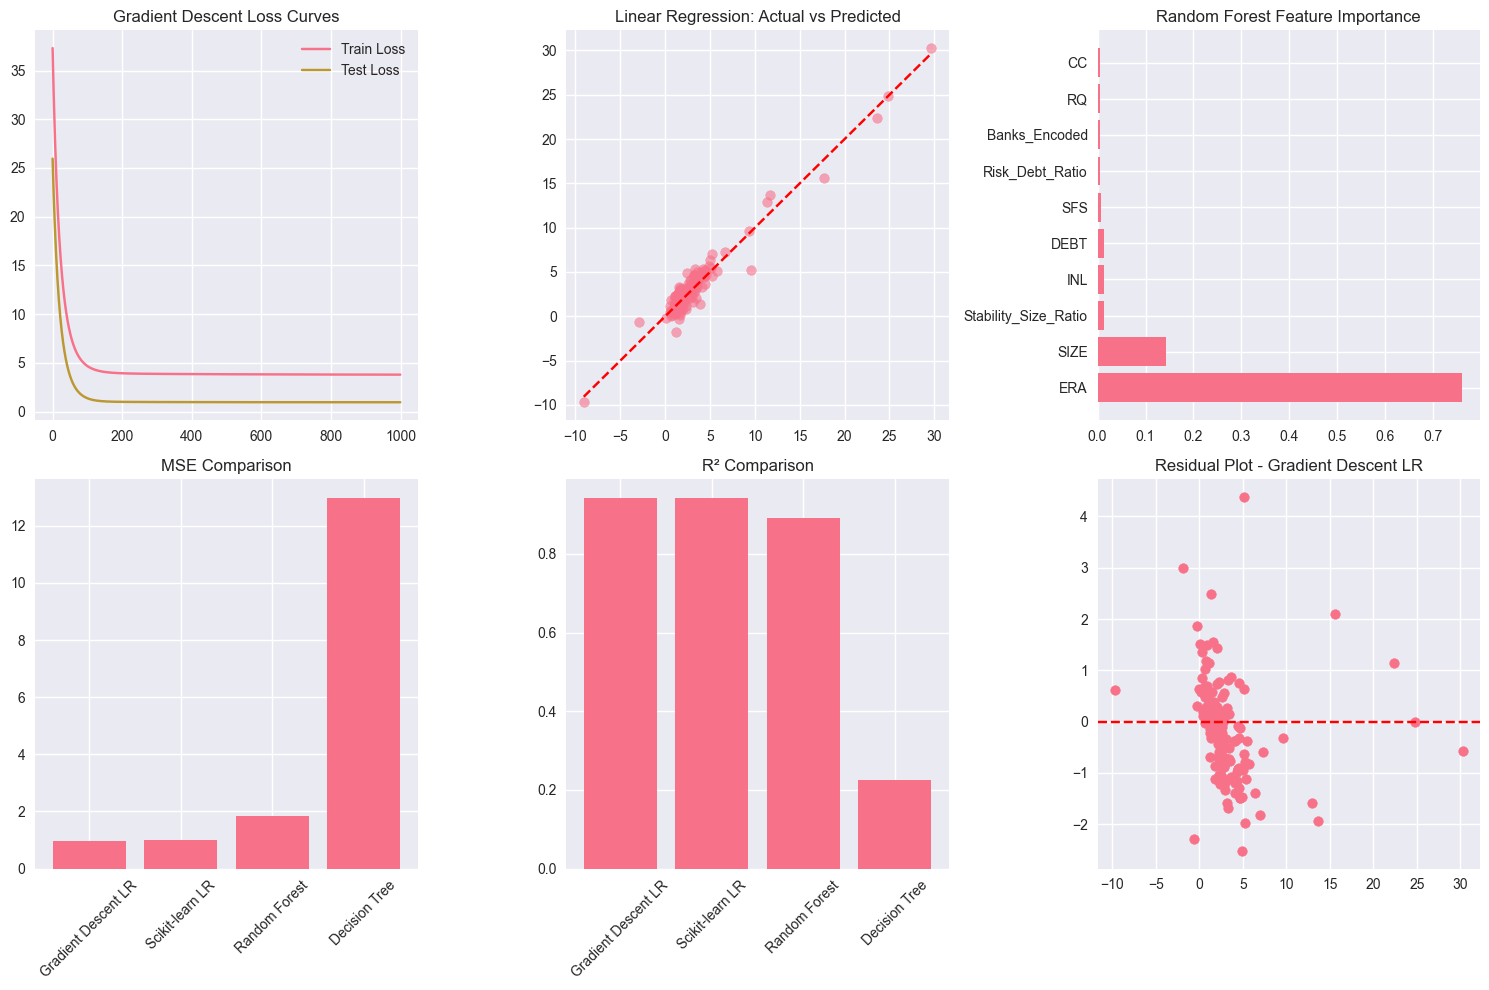

In [30]:
best_model_name = min(models_performance, key=lambda x: models_performance[x]['mse'])
best_model = models_performance[best_model_name]['model']
print(f"🏆 Best Model: {best_model_name}")
print(f"Best MSE: {models_performance[best_model_name]['mse']:.4f}")
print(f"Best R²: {models_performance[best_model_name]['r2']:.4f}")

# Visual comparison
plt.figure(figsize=(15, 10))

# Loss Curve
plt.subplot(2, 3, 1)
plt.plot(gd_model.train_losses, label='Train Loss')
plt.plot(gd_model.test_losses, label='Test Loss')
plt.title('Gradient Descent Loss Curves')
plt.legend()

# Actual vs Predicted
plt.subplot(2, 3, 2)
plt.scatter(y_test, lr_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression: Actual vs Predicted')

# Feature Importance
plt.subplot(2, 3, 3)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Random Forest Feature Importance')

# MSE Comparison
plt.subplot(2, 3, 4)
plt.bar(models_performance.keys(), [m['mse'] for m in models_performance.values()])
plt.title('MSE Comparison')
plt.xticks(rotation=45)

# R² Comparison
plt.subplot(2, 3, 5)
plt.bar(models_performance.keys(), [m['r2'] for m in models_performance.values()])
plt.title('R² Comparison')
plt.xticks(rotation=45)

# Residual Plot
plt.subplot(2, 3, 6)
best_pred = rf_pred if best_model_name == 'Random Forest' else (
    dt_pred if best_model_name == 'Decision Tree' else lr_pred)
residuals = y_test - best_pred
plt.scatter(best_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot - {best_model_name}')

plt.tight_layout()
plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [31]:
print("\n💾 Saving model and preprocessing artifacts...")

# Ensure model directory exists
os.makedirs('model', exist_ok=True)

# Save model and objects
joblib.dump(scaler, 'model/scaler.pkl')
joblib.dump(le_countries, 'model/le_countries.pkl')
joblib.dump(le_banks, 'model/le_banks.pkl')
joblib.dump(feature_cols, 'model/feature_names.pkl')

# Save model
if best_model_name in ['Gradient Descent LR', 'Scikit-learn LR']:
    joblib.dump(lr_model, 'model/best_model.pkl')
else:
    joblib.dump(best_model, 'model/best_model.pkl')

print("✅ Artifacts saved!")



💾 Saving model and preprocessing artifacts...
✅ Artifacts saved!


In [36]:
def predict_bank_health(countries_num, year, rir, sfs, inf, era, inl, debt, size, 
                       cc, ge, ps, rq, rl, va, countries, banks):
    model = joblib.load('model/best_model.pkl')
    scaler = joblib.load('model/scaler.pkl')
    le_countries = joblib.load('model/le_countries.pkl')
    le_banks = joblib.load('model/le_banks.pkl')
    feature_names = joblib.load('model/feature_names.pkl')

    countries_encoded = le_countries.transform([countries])[0] if countries in le_countries.classes_ else 0
    banks_encoded = le_banks.transform([banks])[0] if banks in le_banks.classes_ else 0

    risk_debt_ratio = rir * debt
    stability_size_ratio = sfs / (size + 1)
    governance_performance = (ge + ps) / 2

    features = np.array([[countries_num, year, rir, sfs, inf, era, inl, debt, size,
                         cc, ge, ps, rq, rl, va, countries_encoded, banks_encoded,
                         risk_debt_ratio, stability_size_ratio, governance_performance]])

    features_scaled = scaler.transform(features)
    return float(model.predict(features_scaled)[0])


In [37]:
# Test prediction with a sample
test_idx = 0
sample_data = X_test.iloc[test_idx]
predicted_zscore = predict_bank_health(
    countries_num=sample_data['Countries_Num'],
    year=sample_data['Year'],
    rir=sample_data['RIR'],
    sfs=sample_data['SFS'],
    inf=sample_data['INF'],
    era=sample_data['ERA'],
    inl=sample_data['INL'],
    debt=sample_data['DEBT'],
    size=sample_data['SIZE'],
    cc=sample_data['CC'],
    ge=sample_data['GE'],
    ps=sample_data['PS'],
    rq=sample_data['RQ'],
    rl=sample_data['RL'],
    va=sample_data['VA'],
    countries='Benin',
    banks='Default Bank'
)

actual_zscore = y_test.iloc[test_idx]
print(f"Predicted Z-Score: {predicted_zscore:.4f}")
print(f"Actual Z-Score: {actual_zscore:.4f}")
print(f"Prediction Error: {abs(predicted_zscore - actual_zscore):.4f}")


Predicted Z-Score: 1.3534
Actual Z-Score: 0.9801
Prediction Error: 0.3733


In [39]:
print("\n🎉 UEMOA Banking Risk Assessment Complete!")
print("📁 Files saved: best_model.pkl, scaler.pkl, feature_names.pkl")
print("\n📋 FINAL MODEL SUMMARY:")
print("="*50)
print("🎯 Mission: Predict Bank Financial Health in UEMOA")
print("📊 Dataset: 742 banks across 8 countries (2013-2020)")
print(f"🏆 Best Model: {best_model_name}")
print(f"📈 Performance: MSE = {models_performance[best_model_name]['mse']:.4f}, R² = {models_performance[best_model_name]['r2']:.4f}")
print(f"🔧 Features: {len(feature_cols)} engineered features")



🎉 UEMOA Banking Risk Assessment Complete!
📁 Files saved: best_model.pkl, scaler.pkl, feature_names.pkl

📋 FINAL MODEL SUMMARY:
🎯 Mission: Predict Bank Financial Health in UEMOA
📊 Dataset: 742 banks across 8 countries (2013-2020)
🏆 Best Model: Gradient Descent LR
📈 Performance: MSE = 0.9555, R² = 0.9431
🔧 Features: 20 engineered features
